In [1]:
from IPython.display import clear_output
import time

In [2]:
# ! git clone https://github.com/emmanuel-olateju/movie_recommender.git
! git clone -b optimize-dataloader --single-branch https://github.com/emmanuel-olateju/movie_recommender.git

Cloning into 'movie_recommender'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 58 (delta 32), reused 44 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 1.64 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
import sys
sys.path.append("movie_recommender/modules")
from dataset_loader import MovieLensDataset_Base, MovieLensDataset_Optimized

#### Pre-Loads

In [4]:
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


### Exploratory Data Analysis

#### Movie Ratings Degree Distribution
 - Test for Power-law presenece and scale

In [ ]:
no_ratings_per_movie = [len(movie_feature) for movie_feature in dataset.movie_ratings]
no_ratings_per_user = [len(user_feature) for user_feature in dataset.user_ratings]

movie_rating_rank, movie_rating_frequency = np.unique(no_ratings_per_movie, return_counts=True)
user_rating_rank, user_rating_frequency = np.unique(no_ratings_per_user, return_counts=True)

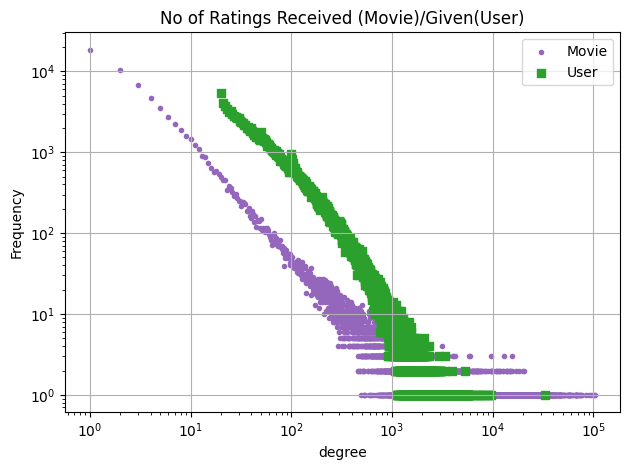

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(movie_rating_rank, movie_rating_frequency, label="Movie", color='C4', marker=".")
plt.scatter(user_rating_rank, user_rating_frequency, label="User", color='C12', marker="s")
plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.xlabel("degree")
plt.ylabel("Frequency")
plt.title("No of Ratings Received (Movie)/Given(User)")

plt.grid()

plt.tight_layout()
plt.savefig("plots/pngs/ratings_distribution.png", format="png", dpi=100)
plt.savefig("plots/pdfs/ratings_distribution.pdf", format="pdf", dpi=100)
# plt.savefig("plots/svgs/ratings_distribution.svg", format="svg", dpi=600)

#### Sparsity & Statistics

In [ ]:
from scipy.sparse import lil_matrix, csr_matrix

N_USERS = len(dataset.users_map)
N_MOVIES = len(dataset.movies_map)

print((N_USERS, N_MOVIES))

# use LIL for fast incremental assignment
heatmap_sparse = lil_matrix((N_USERS, N_MOVIES), dtype=bool)

for movie_key, movie_idx in tqdm(dataset.movies_map.items(), total=N_MOVIES):
    movie_representation = dataset.movie_ratings[movie_idx]

    for rating, user_idx in movie_representation:
        if rating > 0:
            heatmap_sparse[user_idx, movie_idx] = True

# convert to CSR for efficient computation later
heatmap_sparse = heatmap_sparse.tocsr()

100%|██████████| 84432/84432 [03:55<00:00, 358.99it/s]  


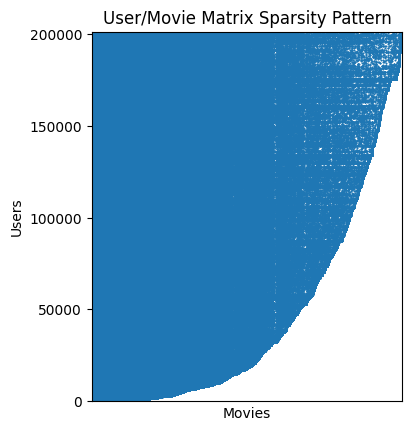

In [ ]:
# @title Sparsity structure of ratings matrix

from matplotlib import pyplot as plt
from scipy.sparse import random
from scipy.sparse import csr_matrix

plt.spy(heatmap_sparse, markersize=0.5, aspect=0.5, origin='lower')
plt.xticks([])
plt.title("User/Movie Matrix Sparsity Pattern")
plt.xlabel("Movies")
plt.ylabel("Users")
# plt.show()

plt.savefig("plots/users_movies_sparsity_representation.svg", format="svg", dpi=50)  # high-res SVG

#### Rating Statistics By User

In [ ]:
mean_rating, rating_variance, n_rating = [], [], []

for user_key, user_idx in dataset.users_map.items():

  user_representation = np.array(dataset.user_ratings[user_idx])

  mean = np.mean(user_representation[:, 0]).item()
  variance = np.var(user_representation[:, 0]).item()

  n_rating.append(len(user_representation))
  mean_rating.append(mean)
  rating_variance.append(variance)

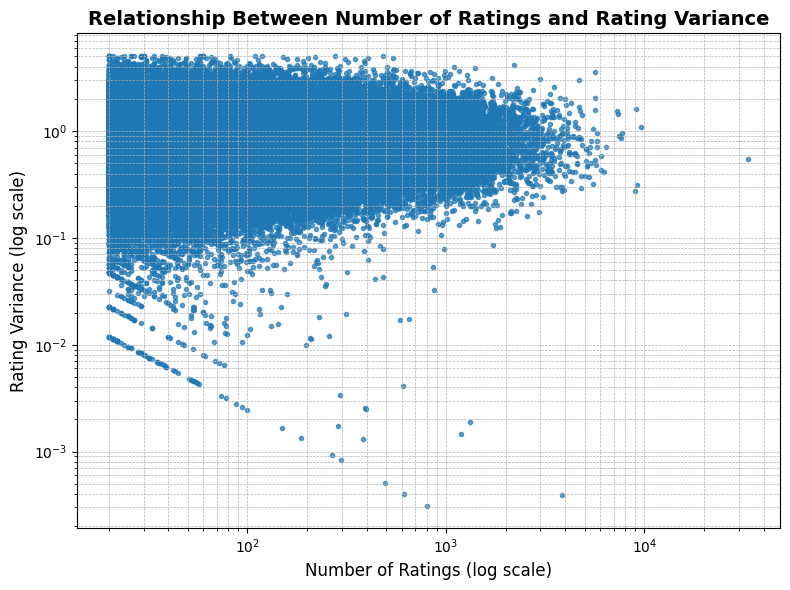

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(n_rating, rating_variance, marker=".", alpha=0.7, rasterized=True)

# Logarithmic scales
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Number of Ratings (log scale)", fontsize=12)
plt.ylabel("Rating Variance (log scale)", fontsize=12)
plt.title("Relationship Between Number of Ratings and Rating Variance", fontsize=14, fontweight='bold')

# Grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Optional: add minor ticks
plt.minorticks_on()

# Optional: adjust layout
plt.tight_layout()

# Show the plot
# plt.show()

plt.savefig("plots/pngs/no_user_ratings_&_rating_variance.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/no_user_ratings_&_rating_variance.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/no_user_ratings_&_rating_variance.svg", format="svg", dpi=100)  # high-res SVG

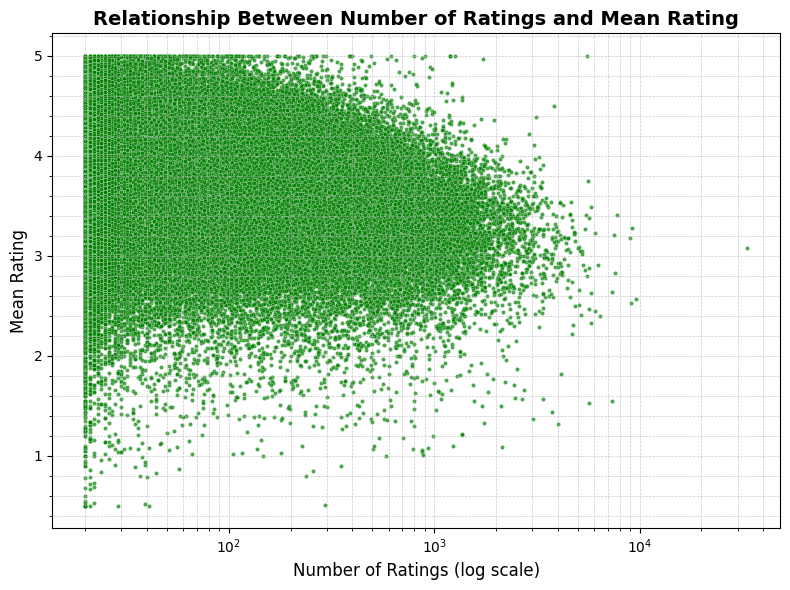

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    n_rating, mean_rating, marker=".",
    alpha=0.7, color='green', edgecolors='w',
    linewidth=0.2, rasterized=True
)

# Logarithmic x-scale
plt.xscale("log")

# Labels and title
plt.xlabel("Number of Ratings (log scale)", fontsize=12)
plt.ylabel("Mean Rating", fontsize=12)
plt.title("Relationship Between Number of Ratings and Mean Rating", fontsize=14, fontweight='bold')

# Grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Optional: add minor ticks
plt.minorticks_on()

# Optional: adjust layout
plt.tight_layout()

# Show the plot
# plt.show()

plt.savefig("plots/pngs/no_user_ratings_&_mean_rating.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/no_user_ratings_&_mean_rating.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/no_user_ratings_&_mean_rating.svg", format="svg", dpi=100)  # high-res SVG

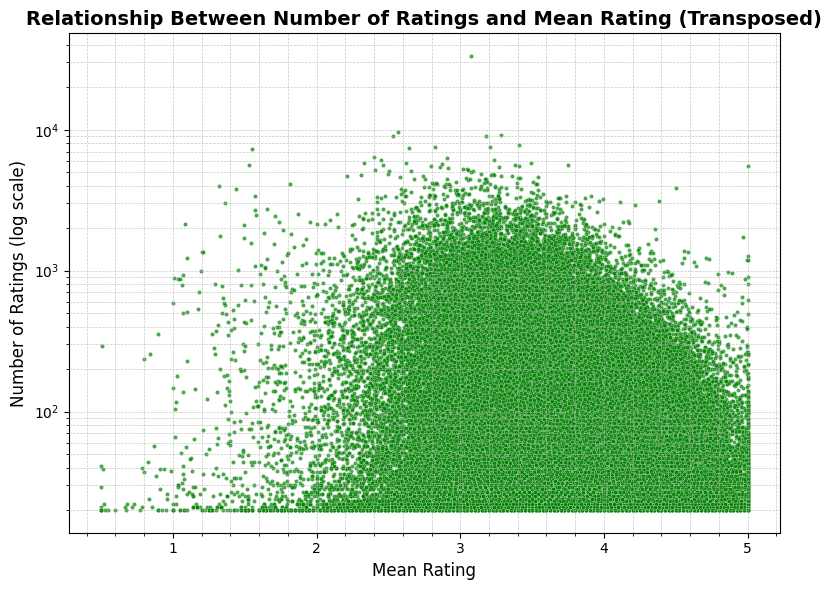

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    mean_rating, n_rating, marker=".",
    alpha=0.7, color='green', edgecolors='w',
    linewidth=0.2, rasterized=True
)

# Logarithmic x-scale
plt.yscale("log")

# Labels and title
plt.ylabel("Number of Ratings (log scale)", fontsize=12)
plt.xlabel("Mean Rating", fontsize=12)
plt.title("Relationship Between Number of Ratings and Mean Rating (Transposed)", fontsize=14, fontweight='bold')

# Grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Optional: add minor ticks
plt.minorticks_on()

# Optional: adjust layout
plt.tight_layout()

# Show the plote
# plt.show()

plt.savefig("plots/pngs/mean_rating_&_no_user_ratings.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/mean_rating_&_no_user_ratings.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/mean_rating_&_no_user_ratings.svg", format="svg", dpi=100)  # high-res SVG

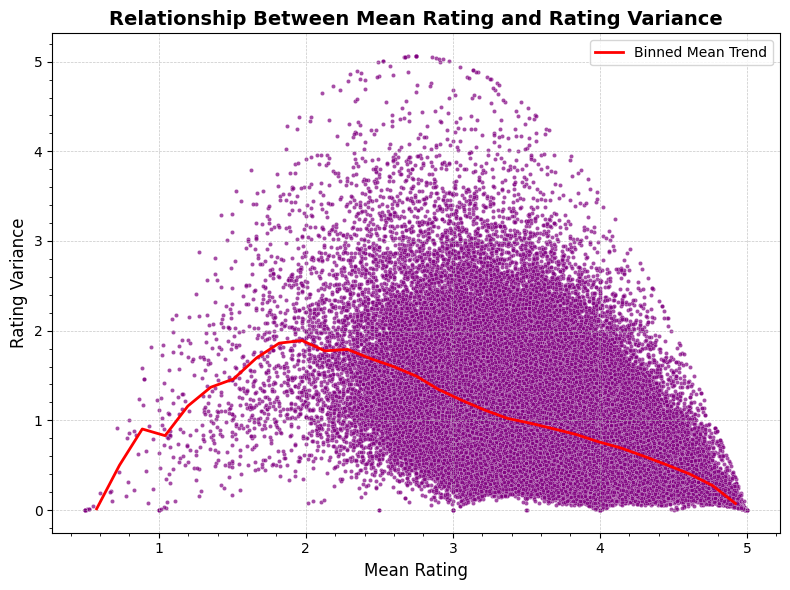

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    mean_rating, rating_variance, marker=".", alpha=0.7,
    color='purple', edgecolors='w',
    linewidth=0.2, rasterized=True
)

# Labels and title
plt.xlabel("Mean Rating", fontsize=12)
plt.ylabel("Rating Variance", fontsize=12)
plt.title("Relationship Between Mean Rating and Rating Variance", fontsize=14, fontweight='bold')

# Grid for readability
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.minorticks_on()

# Optional: trend line using binned mean variance
bins = np.linspace(min(mean_rating), max(mean_rating), 30)
bin_means, _, _ = binned_statistic(mean_rating, rating_variance, statistic='mean', bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, bin_means, color='red', linestyle='-', linewidth=2, label='Binned Mean Trend')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
# plt.show()


plt.savefig("plots/pngs/mean_rating_&_rating_variance.png", format="png", dpi=100)  # high-res SVG
plt.savefig("plots/pdfs/mean_rating_&_rating_variance.pdf", format="pdf", dpi=100)  # high-res SVG
# plt.savefig("plots/svgs/mean_rating_&_rating_variance.svg", format="svg", dpi=100)  # high-res SVG

#### Clusters

In [ ]:
# @title 1.1 Movie Embedding Clusters

# from sklearn.cluster import KMeans

# movies_embedding = get_representations(dataset.movies_map.keys(), get_movie_representation)
# movies_embedding.shape

#### Functions to be ported to librawry

In [ ]:
# @title Load Representation Features

def get_movie_representation(movie_key):

  movie_idx = dataset.movies_map[movie_key]
  result = np.array(dataset.movie_ratings[movie_idx])

  movie_representation = np.zeros([len(dataset.users_map), ])
  non_zero_indices = result[:, 1].astype(int)
  movie_representation[non_zero_indices] = result[:, 0]

  return movie_representation

def get_user_representation(user_key):

  user_idx = dataset.users_map[user_key]
  result = np.array(dataset.user_ratings[user_idx])

  user_representation = np.zeros([len(dataset.movies_map), ])
  non_zero_indices = result[:, 1].astype(int)
  user_representation[non_zero_indices] = result[:, 0]

  return user_representation

def get_representations(indices, fnc):

  result = []
  for idx in tqdm(indices, total=len(indices)):
    result.append(fnc(idx))

  return np.array(result)

# Functions and Classes

In [5]:
# @title Functions

from tqdm import tqdm

def make_representation(rating_list, vector_length):
  if len(rating_list) == 0:
    return np.zeros((vector_length))

  arr = np.array(rating_list)
  vector_pos = arr[:, 1].astype(int)
  rating_values = arr[:, 0]

  vector = np.zeros((vector_length,))
  vector[vector_pos] = rating_values

  return vector

def compute_loss_base_dataset(ds, U, V, BM, BN, lambda_, tau, gamma, mu, mode="train"):
    M = len(ds.user_train)
    N = len(ds.movie_train)

    rating_errors = []
    total_ratings = 0.0

    for m in range(M):
        user_ratings = ds.user_train[m] if mode == "train" else ds.user_test[m]
        if len(user_ratings) == 0:
            continue

        rated_idx = np.array([x[1] for x in user_ratings], dtype=int)
        r_m_rated = np.array([x[0] for x in user_ratings], dtype=float)

        pred_m_rated = mu + V[rated_idx] @ U[m, :] + BM[m] + BN[rated_idx]
        # pred_m_rated = mu + BM[m] + BN[rated_idx]
        rating_errors.append((r_m_rated - pred_m_rated) ** 2)
        total_ratings += len(rated_idx)

    if total_ratings == 0:
        # return float('inf'), float('inf')  # or 0, depending on preference
        return 0.0, 0.0

    rating_error_all = np.concatenate(rating_errors)
    rating_error = np.sum(rating_error_all)

    # RMSE is always just the data fit
    rmse = np.sqrt(rating_error / total_ratings) if total_ratings > 0 else 0.0

    # Loss differs by mode
    if mode == "train":
        users_norm = np.sum(U ** 2)
        movies_norm = np.sum(V ** 2)
        users_bias_squared = np.sum(BM ** 2)
        movies_bias_squared = np.sum(BN ** 2)

        loss = (lambda_ / 2) * rating_error + \
               (gamma / 2) * (users_bias_squared + movies_bias_squared) + \
               (tau / 2) * (users_norm + movies_norm)

    else:
        # Test loss: only data fit (no regularization)
        loss = (lambda_ / 2) * rating_error  # or even just rating_error

    return loss, rmse

def compute_loss_optimized_dataset(ds, U, V, BM, BN, lambda_, tau, gamma, mu, mode="train"):
    M, N = ds.user_movie_counts()

    rating_errors = []
    total_ratings = 0.0

    if mode == 'train':
      users_idx = dataset.users[dataset.train_idx]
      movies_idx = dataset.movies[dataset.train_idx]
      ratings = dataset.ratings[dataset.train_idx]
    else:
      users_idx = dataset.users[dataset.test_idx]
      movies_idx = dataset.movies[dataset.test_idx]
      ratings = dataset.ratings[dataset.test_idx]

    pred_m_rated = mu + np.sum(V[movies_idx] * U[users_idx], axis=1) + BM[users_idx] + BN[movies_idx]
    rating_errors = (ratings - pred_m_rated) ** 2
    total_ratings = len(rating_errors)

    if total_ratings == 0:
      return 0.0, 0.0

    rating_error = np.sum(rating_errors)

    # RMSE is always just the data fit
    rmse = np.sqrt(rating_error / total_ratings) if total_ratings > 0 else 0.0

    # Loss differs by mode
    if mode == "train":
      users_norm = np.sum(U ** 2)
      movies_norm = np.sum(V ** 2)
      users_bias_squared = np.sum(BM ** 2)
      movies_bias_squared = np.sum(BN ** 2)

      loss = (lambda_ / 2) * rating_error + \
              (gamma / 2) * (users_bias_squared + movies_bias_squared) + \
              (tau / 2) * (users_norm + movies_norm)

    else:
      # Test loss: only data fit (no regularization)
      loss = (lambda_ / 2) * rating_error  # or even just rating_error

    return loss, rmse

In [6]:
# @title Experiment Class

from typing import List

import yaml
import numpy as np


class Experiment:

  def __init__(self, name, dir, description, baseline=None):
    self.name = name
    self.dir = dir
    self.description = description
    self.parameters = dict()
    self.baseline = baseline

  def update_param(self, parameter: 'Parameter'):
    var_name = parameter.get_var_name()
    parameter_class = parameter.get_parameter_class()
    value = parameter.get_value()

    assert isinstance(
        value,
        (
            int, float, str, dict, list,
            np.ndarray, torch.tensor, None
        )
    )

    if (parameter_class is None) or (parameter_class.lower() == 'global'):
      self.parameters[var_name] = value
      return

    if parameter_class not in self.parameters:
      self.parameters[parameter_class] = dict()
    self.parameters[parameter_class][var_name] = value

  def save(self):
    experiment_dict = {
        'name': self.name,
        'baseline': self.baseline,
        'description': self.description,
        'parameters': self.parameters,
    }

    with open(self.dir, "w") as f:
      yaml.dump(experiment_dict, f, default_flow_style=False)

    print(f"Model saved to {self.dir}")

  def add_params(self, parameters: List['Parameter']):

    for parameter in parameters:
      self.update_param(parameter)


class Parameter:

  def __init__(self, value, var_name, parameter_class):
    self.__var_name = var_name
    self.__value = value
    self.__parameter_class = parameter_class

  def get_var_name(self):
    return self.__var_name

  def get_parameter_class(self):
    return self.__parameter_class

  def get_value(self):
    return self.__value

  def set_value(self, value):
    self.__value = value

  def set_var_name(self, var_name):
    self.__var_name = var_name

  def set_parameter_class(self, parameter_class):
    self.__parameter_class = parameter_class

# Experiments 0:
- Optimizing Parameter (Bias + Latent Factors) Updates

In [7]:
DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings_small.csv"

In [60]:
# @title Parameter Configurations {"run":"auto","vertical-output":true}

import os
import torch

name = 'v0.0' # @param {type:'string'}

save_folder = f'experiments/{name}' # @param {type:'string'}
save_dir = f'{save_folder}/{name}.yaml'
description = 'Compare Baseline biases update method (user/movies isolated loop update) to single vectorized update' # @param {type:'string'}
baseline_exp = None # @param {type: 'string'}
if os.path.exists(save_folder) is False:
  os.makedirs(save_folder)
experiment = Experiment(
    name,
    save_dir,
    description,
    baseline_exp
)

latent_dim = 10 # @param
K = latent_dim
lambda_ = 20 # @param
gamma = 0.5 # @param
tau = 30.0 # @param
n_epochs = 50 # @param
eval_inter = 5 # @param
batch_size = 30000 # @param

latent_param = Parameter(
    K,
    'embedding_dim',
    'Hyperparameters'
)
lambda_param = Parameter(
    lambda_,
    'residuals_regularizer_lambda',
    'Hyperparameters'
)
gamma_param = Parameter(
    gamma,
    'biases_regularizer_lambda',
    'Hyperparameters'
)
tau_param = Parameter(
    tau,
    'embeddings_regularizer_lambda',
    'Hyperparameters'
)
n_epochs_param = Parameter(
    n_epochs,
    'Epochs',
    'Hyperparameters'
)
eval_inter_param = Parameter(
    eval_inter,
    "Evaluation-Interval",
    "Hyperparameters"
)
batch_size_param = Parameter(
    batch_size,
    "Batch-Size",
    "Hyperparamters"
)

experiment.add_params([
    lambda_param,
    gamma_param,
    tau_param,
    n_epochs_param,
    eval_inter_param,
    batch_size_param
])

## Updating Biases

In [41]:
# @title Isolated Biases updates

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

dataset = MovieLensDataset_Base(DATASET_DIR)
dataset.user_train, dataset.user_test, dataset.movie_train, dataset.movie_test = dataset.train_test_split(
    split_ratio=0.9
)
compute_loss = compute_loss_base_dataset

# Define no of users and movies
M = len(dataset.user_train)
N = len(dataset.movie_train)

# Initialize U and V latent space for users and movies respectively
latent_dim = K = 10
U = np.random.randn(M, K) #* 0.001
V = np.random.randn(N, K) #* 0.001

# Initialize users bias and movies bias
BM = np.random.randn(M)
BN = np.random.randn(N)

mu = np.mean([rating for entry in dataset.user_train for rating, _ in entry])

# Define hyperparametres

# Define training parameters
n_iter = n_epochs
train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []
train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

start_train_loss = train_loss
start_test_loss = test_loss

for epoch in tqdm(range(n_iter), total=n_iter):

  # Update users bias
  # for m in tqdm(range(M), total=M, desc="Optimizing User Embeddings"):
  for m in range(M):
    user_ratings = dataset.user_train[m]
    if len(user_ratings) == 0:
      continue

    rated_idx = np.array([x[1] for x in user_ratings], dtype=int)
    r_m_rated = np.array([x[0] for x in user_ratings], dtype=float)

    pred_m = mu + (V[rated_idx] @ U[m]) + BN[rated_idx]
    residuals = r_m_rated - pred_m
    numerator = lambda_ * np.sum(residuals, axis=0)
    denominator = (lambda_ * len(rated_idx)) + gamma
    BM[m] = numerator / denominator

  # Update movies bias
  # for n in tqdm(range(N), total=N, desc="Optimizing Movie Embeddings"):
  for n in range(N):
    movie_ratings = dataset.movie_train[n]
    if len(movie_ratings) == 0:
      continue

    rated_idx  = np.array([x[1] for x in movie_ratings], dtype=int)
    r__n_rated = np.array([x[0] for x in movie_ratings], dtype=float)

    pred_n = mu + (U[rated_idx] @ V[n]) + BM[rated_idx]
    residuals = r__n_rated - pred_n
    numerator = lambda_ * np.sum(residuals)
    denominator = (lambda_ * len(rated_idx)) + gamma
    BN[n] = numerator / denominator

  train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
  train_loss_history.append(train_loss)
  train_rmse_history.append(train_rmse)

  test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
  test_loss_history.append(test_loss)
  test_rmse_history.append(test_rmse)

  if epoch % eval_inter == 0:
    print(f"Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

isolated_update_performance = {
    "NLL": {
        "train": train_loss_history,
        "test": test_loss_history
    },
    "RMSE": {
        "train": train_rmse_history,
        "test": test_rmse_history
    }
}

train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"END: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

end_train_loss = train_loss
end_test_loss = test_loss

print("-----------------------------------------------")
print(f"Change in  Train Loss: {start_train_loss - end_train_loss:.2f}")
print(f"Change in   Test Loss: {start_test_loss - end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"Start Loss |  Train: {start_train_loss:.2f}, Test: {start_test_loss:.2f}")
print(f"End   Loss |  Train: {end_train_loss:.2f}, Test: {end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"\n{'='*60}")
print(f"Final Loss: {train_loss_history[-1]:.4f}")
print(f"Initial Loss: {train_loss_history[0]:.4f}")
print(f"Loss Reduction: {train_loss_history[0] - train_loss_history[-1]:.4f}")
print(f"User bias range: [{np.min(BM):.4f}, {np.max(BM):.4f}]")
print(f"Movie bias range: [{np.min(BN):.4f}, {np.max(BN):.4f}]")
print(f"{'='*60}")
print("-----------------------------------------------")
# Verify U and V didn't change
print(f"\nVerification - U norm: {np.linalg.norm(U):.4f} (should be same as initial)")
print(f"Verification - V norm: {np.linalg.norm(V):.4f} (should be same as initial)")

  0%|          | 100836/32000204 [00:00<01:06, 476260.92it/s]


START: Train Loss = 13227957.1271, Train RMSE: 3.588188 | Test Loss = 1330208.5737, Test RMSE: 3.614992 | BM mean = -0.0004 | BN mean = 0.0191


  2%|▏         | 1/50 [00:00<00:17,  2.86it/s]

Train Loss = 10143842.4476, Train RMSE: 3.0761 | Test Loss = 1190220.1718, Test RMSE: 3.4195


 12%|█▏        | 6/50 [00:02<00:19,  2.28it/s]

Train Loss = 10101703.3992, Train RMSE: 3.0685 | Test Loss = 1188991.2232, Test RMSE: 3.4177


 22%|██▏       | 11/50 [00:04<00:18,  2.07it/s]

Train Loss = 10101700.4635, Train RMSE: 3.0685 | Test Loss = 1188968.6221, Test RMSE: 3.4177


 32%|███▏      | 16/50 [00:06<00:12,  2.77it/s]

Train Loss = 10101698.7624, Train RMSE: 3.0685 | Test Loss = 1188964.4177, Test RMSE: 3.4177


 42%|████▏     | 21/50 [00:08<00:09,  2.98it/s]

Train Loss = 10101697.1077, Train RMSE: 3.0685 | Test Loss = 1188960.9573, Test RMSE: 3.4177


 52%|█████▏    | 26/50 [00:09<00:07,  3.07it/s]

Train Loss = 10101695.4972, Train RMSE: 3.0685 | Test Loss = 1188957.5982, Test RMSE: 3.4177


 62%|██████▏   | 31/50 [00:11<00:06,  3.10it/s]

Train Loss = 10101693.9297, Train RMSE: 3.0685 | Test Loss = 1188954.3192, Test RMSE: 3.4177


 72%|███████▏  | 36/50 [00:13<00:04,  3.10it/s]

Train Loss = 10101692.4042, Train RMSE: 3.0685 | Test Loss = 1188951.1179, Test RMSE: 3.4177


 82%|████████▏ | 41/50 [00:14<00:02,  3.06it/s]

Train Loss = 10101690.9195, Train RMSE: 3.0685 | Test Loss = 1188947.9923, Test RMSE: 3.4177


 92%|█████████▏| 46/50 [00:16<00:01,  2.24it/s]

Train Loss = 10101689.4745, Train RMSE: 3.0685 | Test Loss = 1188944.9404, Test RMSE: 3.4177


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]

END: Train Loss = 10101688.3463, Train RMSE: 3.068485 | Test Loss = 1188942.5508, Test RMSE: 3.417652 | BM mean = 0.1050 | BN mean = -0.1376
-----------------------------------------------
Change in  Train Loss: 3126268.78
Change in   Test Loss: 141266.02
-----------------------------------------------
Start Loss |  Train: 13227957.13, Test: 1330208.57
End   Loss |  Train: 10101688.35, Test: 1188942.55
-----------------------------------------------

Final Loss: 10101688.3463
Initial Loss: 10143842.4476
Loss Reduction: 42154.1013
User bias range: [-2.5878, 2.1273]
Movie bias range: [-14.5154, 13.2484]
-----------------------------------------------

Verification - U norm: 77.9791 (should be same as initial)
Verification - V norm: 312.2002 (should be same as initial)


In [42]:
# @title Vectorized biases update (non_batched version)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

dataset = MovieLensDataset_Optimized(DATASET_DIR)
dataset.train_idx, dataset.test_idx = dataset.train_test_split(
    split_ratio=0.9
)
compute_loss = compute_loss_optimized_dataset

# Define no of users and movies
M, N = dataset.user_movie_counts()

# Initialize U and V latent space for users and movies respectively
latent_dim = K = 10
U = np.random.randn(M, K) #* 0.001
V = np.random.randn(N, K) #* 0.001

# Initialize users bias and movies bias
BM = np.random.randn(M)
BN = np.random.randn(N)

# mu = np.mean([rating for entry in dataset.user_train for rating, _ in entry])
mu = np.mean(dataset.ratings)

# Define training parameters
n_iter = n_epochs
train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []
train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

start_train_loss = train_loss
start_test_loss = test_loss

users_list = dataset.users.tolist()
movies_list = dataset.movies.tolist()
ratings_list = dataset.ratings.tolist()

users_idxs = np.array(users_list, dtype=np.int64)
movies_idxs = np.array(movies_list, dtype=np.int64)
ratings = np.array(ratings_list, dtype=np.float64)

for epoch in tqdm(range(n_iter), total=n_iter):
  predictions_for_users = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BN[movies_idxs]
  residuals_for_users = ratings - predictions_for_users
  predictions_for_movies = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BM[users_idxs]
  residuals_for_movies = ratings - predictions_for_movies

  # Update User Biases
  per_user_residual_sum = np.bincount(users_idxs, weights=lambda_*residuals_for_users, minlength=M)
  per_user_count = np.bincount(users_idxs, minlength=M)
  mask = per_user_count > 0
  BM[mask] = per_user_residual_sum[mask] / (lambda_ * per_user_count[mask] + gamma)

  # Update Movie Biases
  per_movie_residual_sum = np.bincount(movies_idxs, weights=lambda_*residuals_for_movies, minlength=N)
  per_movie_count = np.bincount(movies_idxs, minlength=N)
  mask = per_movie_count > 0
  BN[mask] = per_movie_residual_sum[mask] / (lambda_ * per_movie_count[mask] + gamma)

  train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
  train_loss_history.append(train_loss)
  train_rmse_history.append(train_rmse)

  test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
  test_loss_history.append(test_loss)
  test_rmse_history.append(test_rmse)

  if epoch % eval_inter == 0:
    print(f"Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

vectorized_update_performance = {
    "NLL": {
        "train": train_loss_history,
        "test": test_loss_history
    },
    "RMSE": {
        "train": train_rmse_history,
        "test": test_rmse_history
    }
}

train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"END: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

end_train_loss = train_loss
end_test_loss = test_loss

print("-----------------------------------------------")
print(f"Change in  Train Loss: {start_train_loss - end_train_loss:.2f}")
print(f"Change in   Test Loss: {start_test_loss - end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"Start Loss |  Train: {start_train_loss:.2f}, Test: {start_test_loss:.2f}")
print(f"End   Loss |  Train: {end_train_loss:.2f}, Test: {end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"\n{'='*60}")
print(f"Final Loss: {train_loss_history[-1]:.4f}")
print(f"Initial Loss: {train_loss_history[0]:.4f}")
print(f"Loss Reduction: {train_loss_history[0] - train_loss_history[-1]:.4f}")
print(f"User bias range: [{np.min(BM):.4f}, {np.max(BM):.4f}]")
print(f"Movie bias range: [{np.min(BN):.4f}, {np.max(BN):.4f}]")
print(f"{'='*60}")
print("-----------------------------------------------")
# Verify U and V didn't change
print(f"\nVerification - U norm: {np.linalg.norm(U):.4f} (should be same as initial)")
print(f"Verification - V norm: {np.linalg.norm(V):.4f} (should be same as initial)")

100%|██████████| 99466/99466 [00:00<00:00, 2141009.26it/s]


START: Train Loss = 12986929.9203, Train RMSE: 3.575875 | Test Loss = 1284163.0641, Test RMSE: 3.592876 | BM mean = -0.0127 | BN mean = 0.0128


  6%|▌         | 3/50 [00:00<00:01, 27.11it/s]

Train Loss = 10153916.2386, Train RMSE: 3.1000 | Test Loss = 946050.7803, Test RMSE: 3.0838


 12%|█▏        | 6/50 [00:00<00:01, 27.51it/s]

Train Loss = 10038630.8530, Train RMSE: 3.0793 | Test Loss = 933838.7259, Test RMSE: 3.0639


 18%|█▊        | 9/50 [00:00<00:01, 27.44it/s]

Train Loss = 10037555.8580, Train RMSE: 3.0791 | Test Loss = 934606.4390, Test RMSE: 3.0651


 30%|███       | 15/50 [00:00<00:01, 28.06it/s]

Train Loss = 10038242.7650, Train RMSE: 3.0792 | Test Loss = 933760.1955, Test RMSE: 3.0637


 42%|████▏     | 21/50 [00:00<00:01, 28.05it/s]

Train Loss = 10037278.0639, Train RMSE: 3.0791 | Test Loss = 934569.9238, Test RMSE: 3.0651


 48%|████▊     | 24/50 [00:00<00:00, 27.16it/s]

Train Loss = 10037961.2315, Train RMSE: 3.0792 | Test Loss = 933733.8020, Test RMSE: 3.0637


 60%|██████    | 30/50 [00:01<00:00, 27.54it/s]

Train Loss = 10037009.6086, Train RMSE: 3.0790 | Test Loss = 934534.4044, Test RMSE: 3.0650


 72%|███████▏  | 36/50 [00:01<00:00, 27.37it/s]

Train Loss = 10037685.8274, Train RMSE: 3.0791 | Test Loss = 933709.0726, Test RMSE: 3.0636


 78%|███████▊  | 39/50 [00:01<00:00, 27.36it/s]

Train Loss = 10036747.9721, Train RMSE: 3.0790 | Test Loss = 934499.6982, Test RMSE: 3.0649


 90%|█████████ | 45/50 [00:01<00:00, 27.82it/s]

Train Loss = 10037417.2475, Train RMSE: 3.0791 | Test Loss = 933685.0529, Test RMSE: 3.0636


100%|██████████| 50/50 [00:01<00:00, 27.58it/s]


END: Train Loss = 10037311.6947, Train RMSE: 3.079050 | Test Loss = 933675.6327, Test RMSE: 3.063586 | BM mean = 0.0171 | BN mean = -0.1747
-----------------------------------------------
Change in  Train Loss: 2949618.23
Change in   Test Loss: 350487.43
-----------------------------------------------
Start Loss |  Train: 12986929.92, Test: 1284163.06
End   Loss |  Train: 10037311.69, Test: 933675.63
-----------------------------------------------

Final Loss: 10037311.6947
Initial Loss: 10153916.2386
Loss Reduction: 116604.5439
User bias range: [-2.8508, 2.0349]
Movie bias range: [-12.9852, 11.7465]
-----------------------------------------------

Verification - U norm: 77.9791 (should be same as initial)
Verification - V norm: 310.5501 (should be same as initial)


In [43]:
# @title Vectorized biases update (batched version)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

dataset = MovieLensDataset_Optimized(DATASET_DIR)
dataset.train_idx, dataset.test_idx = dataset.train_test_split(
    split_ratio=0.9
)
compute_loss = compute_loss_optimized_dataset

# Define no of users and movies
M, N = dataset.user_movie_counts()

# Initialize U and V latent space for users and movies respectively
latent_dim = K = 10
U = np.random.randn(M, K) #* 0.001
V = np.random.randn(N, K) #* 0.001

# Initialize users bias and movies bias
BM = np.random.randn(M)
BN = np.random.randn(N)

# mu = np.mean([rating for entry in dataset.user_train for rating, _ in entry])
mu = np.mean(dataset.ratings)

# Define training parameters
n_iter = n_epochs
train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []
train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

start_train_loss = train_loss
start_test_loss = test_loss

for epoch in tqdm(range(n_iter), total=n_iter):
  samples = np.random.choice(dataset.train_idx, size=batch_size, replace=False)
  users_list = dataset.users[samples].tolist()
  movies_list = dataset.movies[samples].tolist()
  ratings_list = dataset.ratings[samples].tolist()

  users_idxs = np.array(users_list, dtype=np.int64)
  movies_idxs = np.array(movies_list, dtype=np.int64)
  ratings = np.array(ratings_list, dtype=np.float64)

  predictions_for_users = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BN[movies_idxs]
  residuals_for_users = ratings - predictions_for_users
  predictions_for_movies = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BM[users_idxs]
  residuals_for_movies = ratings - predictions_for_movies

  # Update User Biases
  per_user_residual_sum = np.bincount(users_idxs, weights=lambda_*residuals_for_users, minlength=M)
  per_user_count = np.bincount(users_idxs, minlength=M)
  mask = per_user_count > 0
  BM[mask] = per_user_residual_sum[mask] / (lambda_ * per_user_count[mask] + gamma)

  # Update Movie Biases
  per_movie_residual_sum = np.bincount(movies_idxs, weights=lambda_*residuals_for_movies, minlength=N)
  per_movie_count = np.bincount(movies_idxs, minlength=N)
  mask = per_movie_count > 0
  BN[mask] = per_movie_residual_sum[mask] / (lambda_ * per_movie_count[mask] + gamma)

  train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
  train_loss_history.append(train_loss)
  train_rmse_history.append(train_rmse)

  test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
  test_loss_history.append(test_loss)
  test_rmse_history.append(test_rmse)

  if epoch % eval_inter == 0:
    print(f"Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

vectorized_batch_update_performance = {
    "NLL": {
        "train": train_loss_history,
        "test": test_loss_history
    },
    "RMSE": {
        "train": train_rmse_history,
        "test": test_rmse_history
    }
}

train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"END: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

end_train_loss = train_loss
end_test_loss = test_loss

print("-----------------------------------------------")
print(f"Change in  Train Loss: {start_train_loss - end_train_loss:.2f}")
print(f"Change in   Test Loss: {start_test_loss - end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"Start Loss |  Train: {start_train_loss:.2f}, Test: {start_test_loss:.2f}")
print(f"End   Loss |  Train: {end_train_loss:.2f}, Test: {end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"\n{'='*60}")
print(f"Final Loss: {train_loss_history[-1]:.4f}")
print(f"Initial Loss: {train_loss_history[0]:.4f}")
print(f"Loss Reduction: {train_loss_history[0] - train_loss_history[-1]:.4f}")
print(f"User bias range: [{np.min(BM):.4f}, {np.max(BM):.4f}]")
print(f"Movie bias range: [{np.min(BN):.4f}, {np.max(BN):.4f}]")
print(f"{'='*60}")
print("-----------------------------------------------")
# Verify U and V didn't change
print(f"\nVerification - U norm: {np.linalg.norm(U):.4f} (should be same as initial)")
print(f"Verification - V norm: {np.linalg.norm(V):.4f} (should be same as initial)")

100%|██████████| 99466/99466 [00:00<00:00, 2181879.54it/s]


START: Train Loss = 12998939.2625, Train RMSE: 3.576392 | Test Loss = 1272153.7220, Test RMSE: 3.588321 | BM mean = -0.0127 | BN mean = 0.0128


 10%|█         | 5/50 [00:00<00:01, 43.48it/s]

Train Loss = 13893096.9489, Train RMSE: 3.7123 | Test Loss = 1425292.7003, Test RMSE: 3.7982
Train Loss = 14127496.2121, Train RMSE: 3.7464 | Test Loss = 1545635.6447, Test RMSE: 3.9553


 40%|████      | 20/50 [00:00<00:00, 46.34it/s]

Train Loss = 14189155.8583, Train RMSE: 3.7551 | Test Loss = 1576399.5794, Test RMSE: 3.9944
Train Loss = 14027488.1069, Train RMSE: 3.7308 | Test Loss = 1589787.3436, Test RMSE: 4.0114


 60%|██████    | 30/50 [00:00<00:00, 46.58it/s]

Train Loss = 13866359.6390, Train RMSE: 3.7066 | Test Loss = 1563990.2799, Test RMSE: 3.9787
Train Loss = 14070546.3205, Train RMSE: 3.7371 | Test Loss = 1589679.9711, Test RMSE: 4.0112


 70%|███████   | 35/50 [00:00<00:00, 44.70it/s]

Train Loss = 13936429.4202, Train RMSE: 3.7170 | Test Loss = 1597709.7980, Test RMSE: 4.0213
Train Loss = 13738098.7640, Train RMSE: 3.6871 | Test Loss = 1527937.3961, Test RMSE: 3.9326


100%|██████████| 50/50 [00:01<00:00, 45.59it/s]

Train Loss = 13884785.9129, Train RMSE: 3.7092 | Test Loss = 1514927.7901, Test RMSE: 3.9158
Train Loss = 13883805.1164, Train RMSE: 3.7091 | Test Loss = 1536647.2318, Test RMSE: 3.9437
END: Train Loss = 13765172.2160, Train RMSE: 3.691137 | Test Loss = 1525917.3380, Test RMSE: 3.929950 | BM mean = -0.0280 | BN mean = -0.0916
-----------------------------------------------
Change in  Train Loss: -766232.95
Change in   Test Loss: -253763.62
-----------------------------------------------
Start Loss |  Train: 12998939.26, Test: 1272153.72
End   Loss |  Train: 13765172.22, Test: 1525917.34
-----------------------------------------------

Final Loss: 13765172.2160
Initial Loss: 13893096.9489
Loss Reduction: 127924.7329
User bias range: [-12.8631, 6.2377]
Movie bias range: [-14.4632, 13.5665]
-----------------------------------------------

Verification - U norm: 77.9791 (should be same as initial)
Verification - V norm: 310.5501 (should be same as initial)


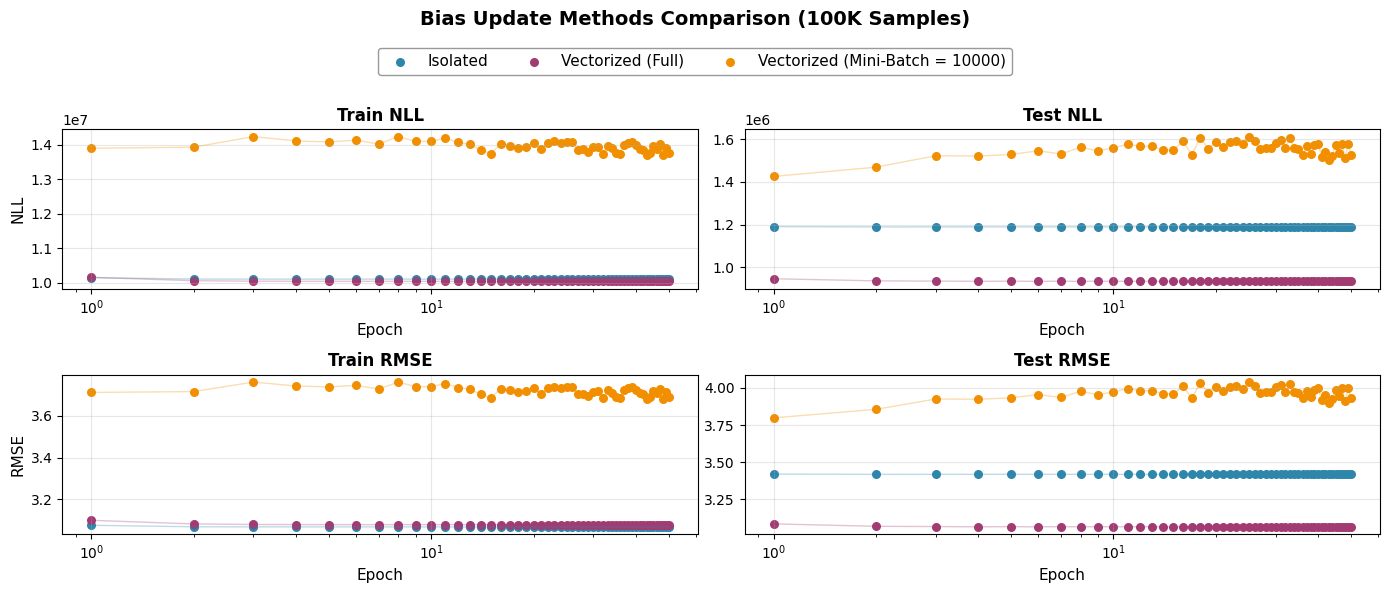

In [44]:
# @title Plot to compare Vectorized to Isolated Bias Updates

from matplotlib.lines import Line2D

# Define distinct colors for each method
colors = {
    'isolated': '#2E86AB',      # Blue
    'vectorized': '#A23B72',    # Purple
    'batch': '#F18F01'          # Orange
}

# Simplified labels for legend
labels = {
    'isolated': 'Isolated',
    'vectorized': 'Vectorized (Full)',
    'batch': f'Vectorized (Mini-Batch = {batch_size})'
}

fig = plt.figure(figsize=(14, 6))
epochs = np.arange(1, n_epochs+1)

# Train NLL
plt.subplot(2, 2, 1)
plt.plot(epochs, isolated_update_performance['NLL']["train"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['NLL']["train"], label=labels['isolated'], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['NLL']["train"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['NLL']["train"], label=labels['vectorized'], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['NLL']["train"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['NLL']["train"], label=labels['batch'], s=30, color=colors['batch'])
plt.xscale('log')
plt.ylabel("NLL", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.grid(alpha=0.3)
plt.title("Train NLL", fontsize=12, fontweight='bold')

# Test NLL
plt.subplot(2, 2, 2)
plt.plot(epochs, isolated_update_performance['NLL']["test"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['NLL']["test"], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['NLL']["test"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['NLL']["test"], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['NLL']["test"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['NLL']["test"], s=30, color=colors['batch'])
plt.xscale('log')
plt.xlabel("Epoch", fontsize=11)
plt.title("Test NLL", fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Train RMSE
plt.subplot(2, 2, 3)
plt.plot(epochs, isolated_update_performance['RMSE']["train"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['RMSE']["train"], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['RMSE']["train"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['RMSE']["train"], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['RMSE']["train"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['RMSE']["train"], s=30, color=colors['batch'])
plt.xscale('log')
plt.ylabel("RMSE", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.grid(alpha=0.3)
plt.title("Train RMSE", fontsize=12, fontweight='bold')

# Test RMSE
plt.subplot(2, 2, 4)
plt.plot(epochs, isolated_update_performance['RMSE']["test"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['RMSE']["test"], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['RMSE']["test"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['RMSE']["test"], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['RMSE']["test"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['RMSE']["test"], s=30, color=colors['batch'])
plt.xscale('log')
plt.xlabel("Epoch", fontsize=11)
plt.title("Test RMSE", fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Get legend from first subplot instead
ax1 = fig.get_axes()[0]
handles, labels_list = ax1.get_legend_handles_labels()

fig.suptitle("Bias Update Methods Comparison (100K Samples)", fontsize=14, fontweight='bold', y=0.98)
fig.legend(handles, labels_list, loc='upper center', bbox_to_anchor=(0.5, 0.93),
           ncol=3, frameon=True, fontsize=11, edgecolor='gray')

plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space for title and legend

os.makedirs(f"{save_folder}/pdfs", exist_ok=True)
os.makedirs(f"{save_folder}/pngs", exist_ok=True)

fig.savefig(f"{save_folder}/pdfs/100K_bias_updates.pdf", format="pdf", dpi=150, bbox_inches='tight')
fig.savefig(f"{save_folder}/pngs/100K_bias_updates.png", format="png", dpi=150, bbox_inches='tight')

## Updating Biases + Latent Factors

In [63]:
# @title Isolated updates (Biases + Latent Factors)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

dataset = MovieLensDataset_Base(DATASET_DIR)
dataset.user_train, dataset.user_test, dataset.movie_train, dataset.movie_test = dataset.train_test_split(
    split_ratio=0.9
)
compute_loss = compute_loss_base_dataset

# Define no of users and movies
M = len(dataset.user_train)
N = len(dataset.movie_train)

# Initialize U and V latent space for users and movies respectively
latent_dim = K = 10
U = np.random.randn(M, K) #* 0.001
V = np.random.randn(N, K) #* 0.001

# Initialize users bias and movies bias
BM = np.random.randn(M)
BN = np.random.randn(N)

mu = np.mean([rating for entry in dataset.user_train for rating, _ in entry])

# Define hyperparametres

# Define training parameters
n_iter = n_epochs
train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []
train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

start_train_loss = train_loss
start_test_loss = test_loss

for epoch in tqdm(range(n_iter), total=n_iter):

  # Update users latent factors
  for m in range(M):
    user_ratings = dataset.user_train[m]
    if len(user_ratings) == 0:
      continue

    rated_idx = np.array([x[1] for x in user_ratings], dtype=int)
    r_m_rated = np.array([x[0] for x in user_ratings], dtype=float)

    # Compute and Update User Latent Factor
    pred_m = mu + BM[m] + BN[rated_idx]
    residuals = r_m_rated - pred_m
    numerator = lambda_ * np.sum(V[rated_idx] * residuals[:, np.newaxis], axis=0)
    denominator = (lambda_ * (V[rated_idx].T @ V[rated_idx])) +  (tau * np.eye(K))
    U[m] = np.linalg.solve(denominator, numerator.T)

  # Update movie latent factors
  for n in range(N):
    movie_ratings = dataset.movie_train[n]
    if len(movie_ratings) == 0:
      continue

    rated_idx  = np.array([x[1] for x in movie_ratings], dtype=int)
    r__n_rated = np.array([x[0] for x in movie_ratings], dtype=float)

    # Compute and Update Movie Latent Factor
    pred_n = mu + BM[rated_idx] + BN[n]
    residuals = r__n_rated - pred_n
    numerator = lambda_ * np.sum(U[rated_idx] * residuals[:, np.newaxis], axis=0)
    denominator = (lambda_ * (U[rated_idx].T @ U[rated_idx])) + (tau * np.eye(K))
    V[n] = np.linalg.solve(denominator, numerator.T)

  # Update users bias
  # for m in tqdm(range(M), total=M, desc="Optimizing User Embeddings"):
  for m in range(M):
    user_ratings = dataset.user_train[m]
    if len(user_ratings) == 0:
      continue

    rated_idx = np.array([x[1] for x in user_ratings], dtype=int)
    r_m_rated = np.array([x[0] for x in user_ratings], dtype=float)

    pred_m = mu + (V[rated_idx] @ U[m]) + BN[rated_idx]
    residuals = r_m_rated - pred_m
    numerator = lambda_ * np.sum(residuals, axis=0)
    denominator = (lambda_ * len(rated_idx)) + gamma
    BM[m] = numerator / denominator

  # Update movies bias
  # for n in tqdm(range(N), total=N, desc="Optimizing Movie Embeddings"):
  for n in range(N):
    movie_ratings = dataset.movie_train[n]
    if len(movie_ratings) == 0:
      continue

    rated_idx  = np.array([x[1] for x in movie_ratings], dtype=int)
    r__n_rated = np.array([x[0] for x in movie_ratings], dtype=float)

    pred_n = mu + (U[rated_idx] @ V[n]) + BM[rated_idx]
    residuals = r__n_rated - pred_n
    numerator = lambda_ * np.sum(residuals)
    denominator = (lambda_ * len(rated_idx)) + gamma
    BN[n] = numerator / denominator

  train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
  train_loss_history.append(train_loss)
  train_rmse_history.append(train_rmse)

  test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
  test_loss_history.append(test_loss)
  test_rmse_history.append(test_rmse)

  if epoch % eval_inter == 0:
    print(f"Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

isolated_update_performance = {
    "NLL": {
        "train": train_loss_history,
        "test": test_loss_history
    },
    "RMSE": {
        "train": train_rmse_history,
        "test": test_rmse_history
    }
}

train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"END: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

end_train_loss = train_loss
end_test_loss = test_loss

print("-----------------------------------------------")
print(f"Change in  Train Loss: {start_train_loss - end_train_loss:.2f}")
print(f"Change in   Test Loss: {start_test_loss - end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"Start Loss |  Train: {start_train_loss:.2f}, Test: {start_test_loss:.2f}")
print(f"End   Loss |  Train: {end_train_loss:.2f}, Test: {end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"\n{'='*60}")
print(f"Final Loss: {train_loss_history[-1]:.4f}")
print(f"Initial Loss: {train_loss_history[0]:.4f}")
print(f"Loss Reduction: {train_loss_history[0] - train_loss_history[-1]:.4f}")
print(f"User bias range: [{np.min(BM):.4f}, {np.max(BM):.4f}]")
print(f"Movie bias range: [{np.min(BN):.4f}, {np.max(BN):.4f}]")
print(f"{'='*60}")
print("-----------------------------------------------")
# Verify U and V didn't change
print(f"\nVerification - U norm: {np.linalg.norm(U):.4f} (should be same as initial)")
print(f"Verification - V norm: {np.linalg.norm(V):.4f} (should be same as initial)")

  0%|          | 100836/32000204 [00:00<02:33, 207161.63it/s]


START: Train Loss = 13256986.1017, Train RMSE: 3.591380 | Test Loss = 1300811.0310, Test RMSE: 3.586115 | BM mean = -0.0004 | BN mean = 0.0191


  2%|▏         | 1/50 [00:01<00:52,  1.07s/it]

Train Loss = 871629.7926, Train RMSE: 0.7964 | Test Loss = 101486.5443, Test RMSE: 1.0017


 12%|█▏        | 6/50 [00:09<01:12,  1.65s/it]

Train Loss = 369471.8376, Train RMSE: 0.5197 | Test Loss = 100728.0778, Test RMSE: 0.9979


 22%|██▏       | 11/50 [00:14<00:44,  1.15s/it]

Train Loss = 345374.8784, Train RMSE: 0.4944 | Test Loss = 113760.6113, Test RMSE: 1.0605


 32%|███▏      | 16/50 [00:22<01:01,  1.81s/it]

Train Loss = 339702.7845, Train RMSE: 0.4873 | Test Loss = 119061.9880, Test RMSE: 1.0849


 42%|████▏     | 21/50 [00:33<01:03,  2.18s/it]

Train Loss = 337087.6921, Train RMSE: 0.4838 | Test Loss = 122038.2689, Test RMSE: 1.0984


 52%|█████▏    | 26/50 [00:40<00:32,  1.35s/it]

Train Loss = 335535.6186, Train RMSE: 0.4817 | Test Loss = 123993.9556, Test RMSE: 1.1072


 62%|██████▏   | 31/50 [00:45<00:21,  1.12s/it]

Train Loss = 334508.9353, Train RMSE: 0.4803 | Test Loss = 125269.3351, Test RMSE: 1.1129


 72%|███████▏  | 36/50 [00:52<00:17,  1.28s/it]

Train Loss = 333767.9625, Train RMSE: 0.4793 | Test Loss = 126103.4739, Test RMSE: 1.1166


 82%|████████▏ | 41/50 [00:57<00:09,  1.10s/it]

Train Loss = 333183.7690, Train RMSE: 0.4785 | Test Loss = 126597.4716, Test RMSE: 1.1187


 92%|█████████▏| 46/50 [01:04<00:05,  1.37s/it]

Train Loss = 332698.0563, Train RMSE: 0.4779 | Test Loss = 126908.1467, Test RMSE: 1.1201


100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

END: Train Loss = 332367.9532, Train RMSE: 0.477446 | Test Loss = 127104.1102, Test RMSE: 1.120977 | BM mean = 0.0345 | BN mean = -0.1069
-----------------------------------------------
Change in  Train Loss: 12924618.15
Change in   Test Loss: 1173706.92
-----------------------------------------------
Start Loss |  Train: 13256986.10, Test: 1300811.03
End   Loss |  Train: 332367.95, Test: 127104.11
-----------------------------------------------

Final Loss: 332367.9532
Initial Loss: 871629.7926
Loss Reduction: 539261.8394
User bias range: [-2.1771, 1.4621]
Movie bias range: [-3.2238, 2.8009]
-----------------------------------------------

Verification - U norm: 49.0660 (should be same as initial)
Verification - V norm: 76.6115 (should be same as initial)


In [65]:
# @title Vectorized biases update (non_batched version) -v2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

dataset = MovieLensDataset_Optimized(DATASET_DIR)
dataset.train_idx, dataset.test_idx = dataset.train_test_split(
    split_ratio=0.9
)
compute_loss = compute_loss_optimized_dataset

# Define no of users and movies
M, N = dataset.user_movie_counts()

# Initialize U and V latent space for users and movies respectively
latent_dim = K = 10
U = np.random.randn(M, K) #* 0.001
V = np.random.randn(N, K) #* 0.001

# Initialize users bias and movies bias
BM = np.random.randn(M)
BN = np.random.randn(N)

# mu = np.mean([rating for entry in dataset.user_train for rating, _ in entry])
mu = np.mean(dataset.ratings)

# Define training parameters
n_iter = n_epochs
train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []
train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

start_train_loss = train_loss
start_test_loss = test_loss

users_list = dataset.users.tolist()
movies_list = dataset.movies.tolist()
ratings_list = dataset.ratings.tolist()

users_idxs = np.array(users_list, dtype=np.int64)
movies_idxs = np.array(movies_list, dtype=np.int64)
ratings = np.array(ratings_list, dtype=np.float64)

for epoch in tqdm(range(n_iter), total=n_iter):

  # Bias removals for latent factors update
  detrended_ratings = ratings - mu - BM[users_idxs] - BN[movies_idxs]

  # Update users latent factor
  for m in range(M):

    mask = (users_idxs == m)
    movies_rated_by_m = movies_idxs[mask]
    ratings_by_m = detrended_ratings[mask]
    if len(movies_rated_by_m) == 0:
      continue

    # Compute numerator: λ * Σ V[rated] * residuals
    numerator = lambda_ * np.sum(
        V[movies_rated_by_m] * ratings_by_m[:, np.newaxis],
        axis = 0
    )
    # Compute denominator: λ * V[rated].T @ V[rated] + τI
    V_rated = V[movies_rated_by_m]
    denominator = lambda_ * (V_rated.T @ V_rated) + (tau * np.eye(K))
    # Update user latent factor
    U[m] = np.linalg.solve(denominator, numerator.T)

  # Update movies latent factor
  for n in range(N):

    mask = (movies_idxs == n)
    users_rating_movie = users_idxs[mask]
    m_ratings_by_u = detrended_ratings[mask]
    if len(m_ratings_by_u) == 0:
      continue

    # Compute numerator: λ * Σ U[rated] * residuals
    numerator = lambda_ * np.sum(
        U[users_rating_movie] * m_ratings_by_u[:, np.newaxis],
        axis = 0
    )
    # Compute denominator: λ * U[rated].T @ U[rated] + τI
    U_rated = U[users_rating_movie]
    denominator = lambda_ * (U_rated.T @ U_rated) + (tau * np.eye(K))
    # Update movie latent factor
    V[n] = np.linalg.solve(denominator, numerator.T)


  # Predictions for biases update
  predictions_for_users = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BN[movies_idxs]
  residuals_for_users = ratings - predictions_for_users
  predictions_for_movies = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BM[users_idxs]
  residuals_for_movies = ratings - predictions_for_movies

  # Update User Biases
  per_user_residual_sum = np.bincount(users_idxs, weights=lambda_*residuals_for_users, minlength=M)
  per_user_count = np.bincount(users_idxs, minlength=M)
  mask = per_user_count > 0
  BM[mask] = per_user_residual_sum[mask] / (lambda_ * per_user_count[mask] + gamma)

  # Update Movie Biases
  per_movie_residual_sum = np.bincount(movies_idxs, weights=lambda_*residuals_for_movies, minlength=N)
  per_movie_count = np.bincount(movies_idxs, minlength=N)
  mask = per_movie_count > 0
  BN[mask] = per_movie_residual_sum[mask] / (lambda_ * per_movie_count[mask] + gamma)

  train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
  train_loss_history.append(train_loss)
  train_rmse_history.append(train_rmse)

  test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
  test_loss_history.append(test_loss)
  test_rmse_history.append(test_rmse)

  if epoch % eval_inter == 0:
    print(f"Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

vectorized_update_performance = {
    "NLL": {
        "train": train_loss_history,
        "test": test_loss_history
    },
    "RMSE": {
        "train": train_rmse_history,
        "test": test_rmse_history
    }
}

train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"END: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

end_train_loss = train_loss
end_test_loss = test_loss

print("-----------------------------------------------")
print(f"Change in  Train Loss: {start_train_loss - end_train_loss:.2f}")
print(f"Change in   Test Loss: {start_test_loss - end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"Start Loss |  Train: {start_train_loss:.2f}, Test: {start_test_loss:.2f}")
print(f"End   Loss |  Train: {end_train_loss:.2f}, Test: {end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"\n{'='*60}")
print(f"Final Loss: {train_loss_history[-1]:.4f}")
print(f"Initial Loss: {train_loss_history[0]:.4f}")
print(f"Loss Reduction: {train_loss_history[0] - train_loss_history[-1]:.4f}")
print(f"User bias range: [{np.min(BM):.4f}, {np.max(BM):.4f}]")
print(f"Movie bias range: [{np.min(BN):.4f}, {np.max(BN):.4f}]")
print(f"{'='*60}")
print("-----------------------------------------------")
# Verify U and V didn't change
print(f"\nVerification - U norm: {np.linalg.norm(U):.4f} (should be same as initial)")
print(f"Verification - V norm: {np.linalg.norm(V):.4f} (should be same as initial)")

100%|██████████| 99466/99466 [00:00<00:00, 2227939.81it/s]


START: Train Loss = 13022875.6086, Train RMSE: 3.578947 | Test Loss = 1248217.3758, Test RMSE: 3.565063 | BM mean = -0.0127 | BN mean = 0.0128


  2%|▏         | 1/50 [00:01<01:36,  1.97s/it]

Train Loss = 821163.7928, Train RMSE: 0.8063 | Test Loss = 63995.0557, Test RMSE: 0.8072


 12%|█▏        | 6/50 [00:13<01:37,  2.21s/it]

Train Loss = 302696.2448, Train RMSE: 0.5119 | Test Loss = 26012.4707, Test RMSE: 0.5147


 22%|██▏       | 11/50 [00:24<01:34,  2.42s/it]

Train Loss = 281991.0181, Train RMSE: 0.4888 | Test Loss = 23647.5581, Test RMSE: 0.4907


 32%|███▏      | 16/50 [00:35<01:15,  2.22s/it]

Train Loss = 277409.6486, Train RMSE: 0.4830 | Test Loss = 23129.9028, Test RMSE: 0.4853


 42%|████▏     | 21/50 [00:46<00:59,  2.07s/it]

Train Loss = 275319.1426, Train RMSE: 0.4802 | Test Loss = 22863.6555, Test RMSE: 0.4825


 52%|█████▏    | 26/50 [00:57<00:52,  2.17s/it]

Train Loss = 274147.1461, Train RMSE: 0.4786 | Test Loss = 22672.2196, Test RMSE: 0.4805


 62%|██████▏   | 31/50 [01:09<00:43,  2.31s/it]

Train Loss = 273350.1304, Train RMSE: 0.4775 | Test Loss = 22513.6288, Test RMSE: 0.4788


 72%|███████▏  | 36/50 [01:20<00:33,  2.41s/it]

Train Loss = 272751.3887, Train RMSE: 0.4767 | Test Loss = 22386.8997, Test RMSE: 0.4774


 82%|████████▏ | 41/50 [01:30<00:18,  2.04s/it]

Train Loss = 272303.0817, Train RMSE: 0.4761 | Test Loss = 22292.0300, Test RMSE: 0.4764


 92%|█████████▏| 46/50 [01:41<00:08,  2.13s/it]

Train Loss = 271961.5032, Train RMSE: 0.4756 | Test Loss = 22220.6399, Test RMSE: 0.4757


100%|██████████| 50/50 [01:51<00:00,  2.23s/it]

END: Train Loss = 271745.2363, Train RMSE: 0.475334 | Test Loss = 22177.4666, Test RMSE: 0.475202 | BM mean = 0.0396 | BN mean = -0.0953
-----------------------------------------------
Change in  Train Loss: 12751130.37
Change in   Test Loss: 1226039.91
-----------------------------------------------
Start Loss |  Train: 13022875.61, Test: 1248217.38
End   Loss |  Train: 271745.24, Test: 22177.47
-----------------------------------------------

Final Loss: 271745.2363
Initial Loss: 821163.7928
Loss Reduction: 549418.5565
User bias range: [-1.8874, 1.4376]
Movie bias range: [-3.1920, 2.0055]
-----------------------------------------------

Verification - U norm: 47.6057 (should be same as initial)
Verification - V norm: 47.6116 (should be same as initial)


In [69]:
# @title Vectorized biases update (batched version)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

dataset = MovieLensDataset_Optimized(DATASET_DIR)
dataset.train_idx, dataset.test_idx = dataset.train_test_split(
    split_ratio=0.9
)
compute_loss = compute_loss_optimized_dataset

# Define no of users and movies
M, N = dataset.user_movie_counts()

# Initialize U and V latent space for users and movies respectively
latent_dim = K = 10
U = np.random.randn(M, K) #* 0.001
V = np.random.randn(N, K) #* 0.001

# Initialize users bias and movies bias
BM = np.random.randn(M)
BN = np.random.randn(N)

# mu = np.mean([rating for entry in dataset.user_train for rating, _ in entry])
mu = np.mean(dataset.ratings)

# Define training parameters
n_iter = n_epochs
train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []
train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

start_train_loss = train_loss
start_test_loss = test_loss

for epoch in tqdm(range(n_iter), total=n_iter):
  samples = np.random.choice(dataset.train_idx, size=batch_size, replace=False)
  users_list = dataset.users[samples].tolist()
  movies_list = dataset.movies[samples].tolist()
  ratings_list = dataset.ratings[samples].tolist()

  users_idxs = np.array(users_list, dtype=np.int64)
  movies_idxs = np.array(movies_list, dtype=np.int64)
  ratings = np.array(ratings_list, dtype=np.float64)

  # Bias removals for latent factors update
  detrended_ratings = ratings - mu - BM[users_idxs] - BN[movies_idxs]

  # Update users latent factor
  for m in range(M):

    mask = (users_idxs == m)
    movies_rated_by_m = movies_idxs[mask]
    ratings_by_m = detrended_ratings[mask]
    if len(movies_rated_by_m) == 0:
      continue

    # Compute numerator: λ * Σ V[rated] * residuals
    numerator = lambda_ * np.sum(
        V[movies_rated_by_m] * ratings_by_m[:, np.newaxis],
        axis = 0
    )
    # Compute denominator: λ * V[rated].T @ V[rated] + τI
    V_rated = V[movies_rated_by_m]
    denominator = lambda_ * (V_rated.T @ V_rated) + (tau * np.eye(K))
    # Update user latent factor
    U[m] = np.linalg.solve(denominator, numerator.T)

  # Update movies latent factor
  for n in range(N):

    mask = (movies_idxs == n)
    users_rating_movie = users_idxs[mask]
    m_ratings_by_u = detrended_ratings[mask]
    if len(m_ratings_by_u) == 0:
      continue

    # Compute numerator: λ * Σ U[rated] * residuals
    numerator = lambda_ * np.sum(
        U[users_rating_movie] * m_ratings_by_u[:, np.newaxis],
        axis = 0
    )
    # Compute denominator: λ * U[rated].T @ U[rated] + τI
    U_rated = U[users_rating_movie]
    denominator = lambda_ * (U_rated.T @ U_rated) + (tau * np.eye(K))
    # Update movie latent factor
    V[n] = np.linalg.solve(denominator, numerator.T)

  predictions_for_users = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BN[movies_idxs]
  residuals_for_users = ratings - predictions_for_users
  predictions_for_movies = mu + np.sum(U[users_idxs] * V[movies_idxs], axis=1) + BM[users_idxs]
  residuals_for_movies = ratings - predictions_for_movies

  # Update User Biases
  per_user_residual_sum = np.bincount(users_idxs, weights=lambda_*residuals_for_users, minlength=M)
  per_user_count = np.bincount(users_idxs, minlength=M)
  mask = per_user_count > 0
  BM[mask] = per_user_residual_sum[mask] / (lambda_ * per_user_count[mask] + gamma)

  # Update Movie Biases
  per_movie_residual_sum = np.bincount(movies_idxs, weights=lambda_*residuals_for_movies, minlength=N)
  per_movie_count = np.bincount(movies_idxs, minlength=N)
  mask = per_movie_count > 0
  BN[mask] = per_movie_residual_sum[mask] / (lambda_ * per_movie_count[mask] + gamma)

  train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
  train_loss_history.append(train_loss)
  train_rmse_history.append(train_rmse)

  test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
  test_loss_history.append(test_loss)
  test_rmse_history.append(test_rmse)

  if epoch % eval_inter == 0:
    print(f"Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

vectorized_batch_update_performance = {
    "NLL": {
        "train": train_loss_history,
        "test": test_loss_history
    },
    "RMSE": {
        "train": train_rmse_history,
        "test": test_rmse_history
    }
}

train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
print(f"END: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

end_train_loss = train_loss
end_test_loss = test_loss

print("-----------------------------------------------")
print(f"Change in  Train Loss: {start_train_loss - end_train_loss:.2f}")
print(f"Change in   Test Loss: {start_test_loss - end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"Start Loss |  Train: {start_train_loss:.2f}, Test: {start_test_loss:.2f}")
print(f"End   Loss |  Train: {end_train_loss:.2f}, Test: {end_test_loss:.2f}")
print("-----------------------------------------------")
print(f"\n{'='*60}")
print(f"Final Loss: {train_loss_history[-1]:.4f}")
print(f"Initial Loss: {train_loss_history[0]:.4f}")
print(f"Loss Reduction: {train_loss_history[0] - train_loss_history[-1]:.4f}")
print(f"User bias range: [{np.min(BM):.4f}, {np.max(BM):.4f}]")
print(f"Movie bias range: [{np.min(BN):.4f}, {np.max(BN):.4f}]")
print(f"{'='*60}")
print("-----------------------------------------------")
# Verify U and V didn't change
print(f"\nVerification - U norm: {np.linalg.norm(U):.4f} (should be same as initial)")
print(f"Verification - V norm: {np.linalg.norm(V):.4f} (should be same as initial)")

100%|██████████| 99466/99466 [00:00<00:00, 1396720.52it/s]


START: Train Loss = 12970873.9469, Train RMSE: 3.575144 | Test Loss = 1300219.0375, Test RMSE: 3.599203 | BM mean = -0.0127 | BN mean = 0.0128


  2%|▏         | 1/50 [00:01<01:12,  1.49s/it]

Train Loss = 1614535.2511, Train RMSE: 1.0476 | Test Loss = 136993.8864, Test RMSE: 1.1683


 12%|█▏        | 6/50 [00:07<00:43,  1.01it/s]

Train Loss = 604114.1475, Train RMSE: 0.7194 | Test Loss = 84997.5590, Test RMSE: 0.9202


 22%|██▏       | 11/50 [00:13<00:44,  1.15s/it]

Train Loss = 532813.5078, Train RMSE: 0.6965 | Test Loss = 85488.4181, Test RMSE: 0.9229


 32%|███▏      | 16/50 [00:16<00:27,  1.26it/s]

Train Loss = 518371.2676, Train RMSE: 0.6894 | Test Loss = 85838.6071, Test RMSE: 0.9248


 42%|████▏     | 21/50 [00:20<00:21,  1.37it/s]

Train Loss = 518496.4358, Train RMSE: 0.6900 | Test Loss = 86353.9972, Test RMSE: 0.9276


 52%|█████▏    | 26/50 [00:25<00:24,  1.01s/it]

Train Loss = 513408.8272, Train RMSE: 0.6854 | Test Loss = 85337.8987, Test RMSE: 0.9221


 62%|██████▏   | 31/50 [00:29<00:15,  1.22it/s]

Train Loss = 515369.4132, Train RMSE: 0.6874 | Test Loss = 85868.8332, Test RMSE: 0.9249


 72%|███████▏  | 36/50 [00:33<00:10,  1.35it/s]

Train Loss = 512757.4317, Train RMSE: 0.6854 | Test Loss = 84604.4985, Test RMSE: 0.9181


 82%|████████▏ | 41/50 [00:36<00:06,  1.32it/s]

Train Loss = 516995.2020, Train RMSE: 0.6881 | Test Loss = 86472.3377, Test RMSE: 0.9282


 92%|█████████▏| 46/50 [00:42<00:03,  1.07it/s]

Train Loss = 515698.8130, Train RMSE: 0.6872 | Test Loss = 84794.7014, Test RMSE: 0.9191


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]

END: Train Loss = 514739.8267, Train RMSE: 0.686697 | Test Loss = 84629.1879, Test RMSE: 0.918244 | BM mean = 0.0368 | BN mean = -0.0863
-----------------------------------------------
Change in  Train Loss: 12456134.12
Change in   Test Loss: 1215589.85
-----------------------------------------------
Start Loss |  Train: 12970873.95, Test: 1300219.04
End   Loss |  Train: 514739.83, Test: 84629.19
-----------------------------------------------

Final Loss: 514739.8267
Initial Loss: 1614535.2511
Loss Reduction: 1099795.4244
User bias range: [-2.0234, 1.7802]
Movie bias range: [-3.0793, 4.2020]
-----------------------------------------------

Verification - U norm: 25.3145 (should be same as initial)
Verification - V norm: 73.9224 (should be same as initial)


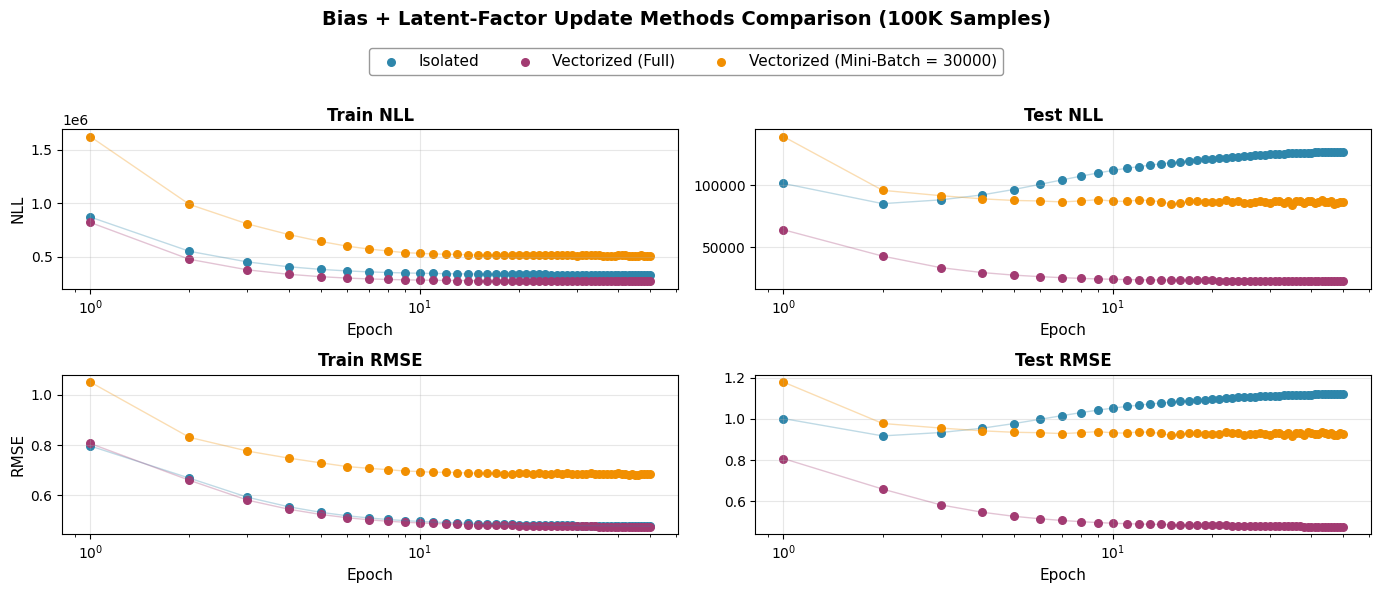

In [67]:
# @title Plot to compare Vectorized to Isolated Bias Updates

from matplotlib.lines import Line2D

# Define distinct colors for each method
colors = {
    'isolated': '#2E86AB',      # Blue
    'vectorized': '#A23B72',    # Purple
    'batch': '#F18F01'          # Orange
}

# Simplified labels for legend
labels = {
    'isolated': 'Isolated',
    'vectorized': 'Vectorized (Full)',
    'batch': f'Vectorized (Mini-Batch = {batch_size})'
}

fig = plt.figure(figsize=(14, 6))
epochs = np.arange(1, n_epochs+1)

# Train NLL
plt.subplot(2, 2, 1)
plt.plot(epochs, isolated_update_performance['NLL']["train"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['NLL']["train"], label=labels['isolated'], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['NLL']["train"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['NLL']["train"], label=labels['vectorized'], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['NLL']["train"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['NLL']["train"], label=labels['batch'], s=30, color=colors['batch'])
plt.xscale('log')
plt.ylabel("NLL", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.grid(alpha=0.3)
plt.title("Train NLL", fontsize=12, fontweight='bold')

# Test NLL
plt.subplot(2, 2, 2)
plt.plot(epochs, isolated_update_performance['NLL']["test"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['NLL']["test"], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['NLL']["test"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['NLL']["test"], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['NLL']["test"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['NLL']["test"], s=30, color=colors['batch'])
plt.xscale('log')
plt.xlabel("Epoch", fontsize=11)
plt.title("Test NLL", fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Train RMSE
plt.subplot(2, 2, 3)
plt.plot(epochs, isolated_update_performance['RMSE']["train"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['RMSE']["train"], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['RMSE']["train"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['RMSE']["train"], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['RMSE']["train"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['RMSE']["train"], s=30, color=colors['batch'])
plt.xscale('log')
plt.ylabel("RMSE", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.grid(alpha=0.3)
plt.title("Train RMSE", fontsize=12, fontweight='bold')

# Test RMSE
plt.subplot(2, 2, 4)
plt.plot(epochs, isolated_update_performance['RMSE']["test"], alpha=0.3, linewidth=1, color=colors['isolated'])
plt.scatter(epochs, isolated_update_performance['RMSE']["test"], s=30, color=colors['isolated'])
plt.plot(epochs, vectorized_update_performance['RMSE']["test"], alpha=0.3, linewidth=1, color=colors['vectorized'])
plt.scatter(epochs, vectorized_update_performance['RMSE']["test"], s=30, color=colors['vectorized'])
plt.plot(epochs, vectorized_batch_update_performance['RMSE']["test"], alpha=0.3, linewidth=1, color=colors['batch'])
plt.scatter(epochs, vectorized_batch_update_performance['RMSE']["test"], s=30, color=colors['batch'])
plt.xscale('log')
plt.xlabel("Epoch", fontsize=11)
plt.title("Test RMSE", fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Get legend from first subplot instead
ax1 = fig.get_axes()[0]
handles, labels_list = ax1.get_legend_handles_labels()

fig.suptitle("Bias + Latent-Factor Update Methods Comparison (100K Samples)", fontsize=14, fontweight='bold', y=0.98)
fig.legend(handles, labels_list, loc='upper center', bbox_to_anchor=(0.5, 0.93),
           ncol=3, frameon=True, fontsize=11, edgecolor='gray')

plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space for title and legend

os.makedirs(f"{save_folder}/pdfs", exist_ok=True)
os.makedirs(f"{save_folder}/pngs", exist_ok=True)

fig.savefig(f"{save_folder}/pdfs/100K_bias+latentFactor_updates.pdf", format="pdf", dpi=150, bbox_inches='tight')
fig.savefig(f"{save_folder}/pngs/100K_bias+latentFactor_updates.png", format="png", dpi=150, bbox_inches='tight')

# Experiments 1: Full Dataset Bias + Latent Factors Update

In [ ]:
DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings.csv"

#### Practical 4

In [ ]:
DATASET_DIR = "drive/MyDrive/datasets/ML_@_SCALE/ratings.csv"
dataset = MovieLensDataset(DATASET_DIR)

100%|██████████| 32000204/32000204 [01:48<00:00, 295628.08it/s]


In [ ]:
dataset.user_train, dataset.user_test, dataset.movie_train, dataset.movie_test = make_training_test_set(
    ds=dataset, split_ratio=0.9
)


Final Loss: 16162829.9998
Initial Loss: 21529970.3625
Loss Reduction: 5367140.3627
User bias range: [-3.1441, 2.2848]
Movie bias range: [-3.3795, 2.6550]


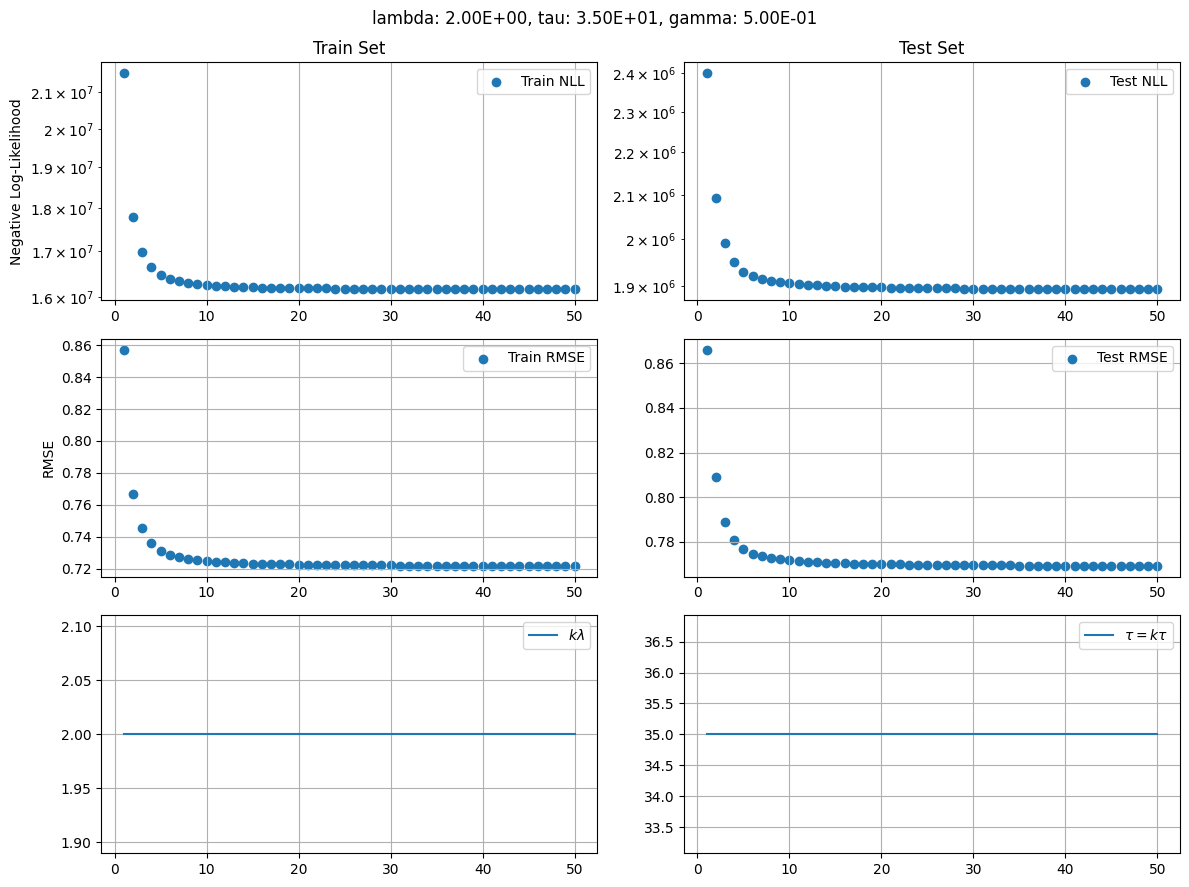

In [ ]:
# @title Update Biases & Latent Factors (Full Dataset) --> Practical 4

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Define no of users and movies
M = len(dataset.user_train)
N = len(dataset.movie_train)

# Initialize U and V latent space for users and movies respectively
latent_dim = K = 10
# U = np.random.randn(M, K) * 0.00001
# V = np.random.randn(N, K) * 0.00001
# U = np.zeros((M, K))
# V = np.zeros((N, K))
# U = np.random.uniform(size=(M,K))
# V = np.random.uniform(size=(N, K))
U = np.random.normal(loc=0, scale=0.01, size=(M, K))
V = np.random.normal(loc=0, scale=0.01, size=(N, K))

# Initialize users bias and movies bias
# BM = np.random.randn(M)
# BN = np.random.randn(N)
BM = np.zeros(M)
BN = np.zeros(N)

# Define hyperparametres
lambda_ = 2.0
tau = 35.0
gamma = 0.5
# mu = [rating for entry in dataset.user_train for rating, _ in entry ]
# mu = np.mean(mu)
# mu = 3.28
mu = np.mean([rating for entry in dataset.user_train for rating, _ in entry])

# Define training parameters
n_iter = 50
train_loss_history = []
train_rmse_history = []
test_loss_history = []
test_rmse_history = []
tau_history = []
lambda_history = []
gamma_history = []

tau_steps = 0
lambda_steps = 0
gamma_steps = 0

train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")

print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")
# print(f"START: Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.6f} | BM mean = {np.mean(BM):.4f} | BN mean = {np.mean(BN):.4f}")

for epoch in tqdm(range(n_iter), total=n_iter):

  # Update users latent factors
  for m in range(M):
    user_ratings = dataset.user_train[m]
    if len(user_ratings) == 0:
      continue

    rated_idx = np.array([x[1] for x in user_ratings], dtype=int)
    r_m_rated = np.array([x[0] for x in user_ratings], dtype=float)

    # Compute and Update User Latent Factor
    pred_m = mu + BM[m] + BN[rated_idx]
    residuals = r_m_rated - pred_m
    numerator = lambda_ * np.sum(V[rated_idx] * residuals[:, np.newaxis], axis=0)
    denominator = (lambda_ * (V[rated_idx].T @ V[rated_idx])) +  (tau * np.eye(K))
    U[m] = np.linalg.solve(denominator, numerator.T)

  # Update movie latent factors
  for n in range(N):
    movie_ratings = dataset.movie_train[n]
    if len(movie_ratings) == 0:
      continue

    rated_idx  = np.array([x[1] for x in movie_ratings], dtype=int)
    r__n_rated = np.array([x[0] for x in movie_ratings], dtype=float)

    # Compute and Update Movie Latent Factor
    pred_n = mu + BM[rated_idx] + BN[n]
    residuals = r__n_rated - pred_n
    numerator = lambda_ * np.sum(U[rated_idx] * residuals[:, np.newaxis], axis=0)
    denominator = (lambda_ * (U[rated_idx].T @ U[rated_idx])) + (tau * np.eye(K))
    V[n] = np.linalg.solve(denominator, numerator.T)

  # Update users bias
  # for m in tqdm(range(M), total=M, desc="Optimizing User Embeddings"):
  for m in range(M):
    user_ratings = dataset.user_train[m]
    if len(user_ratings) == 0:
      continue

    rated_idx = np.array([x[1] for x in user_ratings], dtype=int)
    r_m_rated = np.array([x[0] for x in user_ratings], dtype=float)

    pred_m = mu + (V[rated_idx] @ U[m]) + BN[rated_idx]
    residuals = r_m_rated - pred_m
    numerator = lambda_ * np.sum(residuals, axis=0)
    denominator = (lambda_ * len(rated_idx)) + gamma
    BM[m] = numerator / denominator

  # Update movies bias
  # for n in tqdm(range(N), total=N, desc="Optimizing Movie Embeddings"):
  for n in range(N):
    movie_ratings = dataset.movie_train[n]
    if len(movie_ratings) == 0:
      continue

    rated_idx  = np.array([x[1] for x in movie_ratings], dtype=int)
    r__n_rated = np.array([x[0] for x in movie_ratings], dtype=float)

    pred_n = mu + (U[rated_idx] @ V[n]) + BM[rated_idx]
    residuals = r__n_rated - pred_n
    numerator = lambda_ * np.sum(residuals)
    denominator = (lambda_ * len(rated_idx)) + gamma
    BN[n] = numerator / denominator


  train_loss, train_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu)
  train_loss_history.append(train_loss)
  train_rmse_history.append(train_rmse)

  test_loss, test_rmse = compute_loss(dataset, U, V, BM, BN,  lambda_, tau, gamma, mu, mode="test")
  test_loss_history.append(test_loss)
  test_rmse_history.append(test_rmse)

  tau_history.append(tau)
  lambda_history.append(lambda_)
  gamma_history.append(gamma)

  if epoch % 1 == 0:
    print(f"(Tau: {tau:.2E}, lambda: {lambda_:.2E}, gamma: {gamma:.2E}) --> Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | Test Loss = {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")
    # print(f"Train Loss = {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")

  # if (epoch % 20 == 0):
  #   tau *= np.exp(tau_steps/10)
  #   tau_steps += 1

  # if (epoch % 20 == 0):
  #   lambda_ *= np.exp(-lambda_steps/10)
  #   lambda_steps += 1

# time.sleep(0.25)
# clear_output()

print(f"\n{'='*60}")
print(f"Final Loss: {train_loss_history[-1]:.4f}")
print(f"Initial Loss: {train_loss_history[0]:.4f}")
print(f"Loss Reduction: {train_loss_history[0] - train_loss_history[-1]:.4f}")
print(f"User bias range: [{np.min(BM):.4f}, {np.max(BM):.4f}]")
print(f"Movie bias range: [{np.min(BN):.4f}, {np.max(BN):.4f}]")
print(f"{'='*60}")


fig = plt.figure(figsize=(12, 9))


min_ = min(train_loss_history + test_loss_history)
max_ = max(train_loss_history + test_loss_history)
range_ = max_ - min_
min_, max_ = min_ - 0.1*range_, max_ + 0.1*range_
plt.subplot(3, 2, 1)
plt.scatter(np.arange(1, len(train_loss_history)+1), train_loss_history, label="Train NLL")
# plt.ylim([min_, max_])
plt.yscale('log')
# plt.xscale('log')
plt.ylabel("Negative Log-Likelihood")
plt.title("Train Set")
plt.grid()
plt.legend()

plt.subplot(3, 2, 2)
plt.scatter(np.arange(1, len(test_loss_history)+1), test_loss_history, label="Test NLL")
# plt.ylim([min_, max_])
plt.yscale('log')
# plt.xscale('log')
# plt.ylabel("Negative Log-Likelihood")
plt.title("Test Set")
plt.grid()
plt.legend()


min_ = min(train_rmse_history + test_rmse_history)
max_ = max(train_rmse_history + test_rmse_history)
range_ = max_ - min_
min_, max_ = min_ - 0.1*range_, max_ + 0.1*range_
plt.subplot(3, 2, 3)
plt.scatter(np.arange(1, len(train_rmse_history)+1), train_rmse_history, label="Train RMSE")
# plt.ylim([min_, max_])
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel("RMSE")
# plt.title("Train Set")
plt.grid()
plt.legend()

plt.subplot(3, 2, 4)
plt.scatter(np.arange(1, len(test_rmse_history)+1), test_rmse_history, label="Test RMSE")
# plt.ylim([min_, max_])
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel("RMSE")
# plt.title("Test Set")
plt.grid()
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(np.arange(1, len(lambda_history)+1), lambda_history, label=r"$k\lambda$")
# plt.plot(np.arange(1, len(gamma_history)+1), gamma_history, label=r"$\gamma$")
# plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(np.arange(1, len(tau_history)+1), tau_history, label=r"$\tau = k\tau$")
# plt.plot(np.arange(1, len(tau_history)+1), (np.arange(0, len(tau_history)) // 5).astype(int), label=r"$k$")
# plt.plot(np.arange(1, len(gamma_history)+1), gamma_history, label=r"$\gamma$")
# plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.legend()

fig.suptitle(f"lambda: {lambda_:.2E}, tau: {tau:.2E}, gamma: {gamma:.2E}")
fig.tight_layout()

fig.savefig("plots/Full_dataset_performance.svg", format='svg', dpi=600, bbox_inches="tight")

#### Practical 5

# Save Artifacts & Plots

In [ ]:
from google.colab import files

file_name = "embeddings_&_biases.npz"
np.savez(
    file_name,
    user_embeddings = U,
    movie_embeddings = V,
    user_biases = BM,
    movie_biases = BN
  )

files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

file_name = "hyperparameters.npz"
np.savez(
    file_name,
    lambda_ = lambda_,
    tau = tau,
    gamma = gamma,
  )

files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! zip -r ml-25m_analysis_plots.zip plots/*

  adding: plots/pdfs/ (stored 0%)
  adding: plots/pdfs/ratings_distribution.pdf (deflated 7%)
  adding: plots/pdfs/100K_bias_updates.pdf (deflated 28%)
  adding: plots/pdfs/mean_rating_&_rating_variance.pdf (deflated 3%)
  adding: plots/pdfs/no_user_ratings_&_mean_rating.pdf (deflated 3%)
  adding: plots/pdfs/no_user_ratings_&_rating_variance.pdf (deflated 13%)
  adding: plots/pdfs/mean_rating_&_no_user_ratings.pdf (deflated 3%)
  adding: plots/pdfs/100K_bias+latent_factors_updates.pdf (deflated 31%)
  adding: plots/pngs/ (stored 0%)
  adding: plots/pngs/mean_rating_&_rating_variance.png (deflated 2%)
  adding: plots/pngs/ratings_distribution.png (deflated 8%)
  adding: plots/pngs/no_user_ratings_&_rating_variance.png (deflated 11%)
  adding: plots/pngs/mean_rating_&_no_user_ratings.png (deflated 3%)
  adding: plots/pngs/100K_bias+latent_factorsupdates.png (deflated 20%)
  adding: plots/pngs/no_user_ratings_&_mean_rating.png (deflated 4%)
  adding: plots/pngs/100K_bias_updates.png (def

In [ ]:
from google.colab import files
files.download("ml-25m_analysis_plots.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Downlaod Notebook as PDF

In [ ]:
! apt-get install texlive texlive-xetex texlive-latex-extra pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto f

In [ ]:
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/ml-25m_analysis.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ml-25m_analysis.ipynb to PDF
[NbConvertApp] Support files will be in ml-25m_analysis_files/
[NbConvertApp] Making directory ./ml-25m_analysis_files
[NbConvertApp] Writing 184142 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1481435 bytes to /content/drive/MyDrive/Colab Notebooks/ml-25m_analysis.pdf
